# PA2 - Image Stitching 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# 1. load images
img_left = cv2.imread('imgpairs/tower_left.jpg')
img_right = cv2.imread('imgpairs/tower_right.jpg')

# create grayscale copies
imgL_gray = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

# generate descriptors using SIFT
sift = cv2.SIFT_create()

# find keypoints and descriptors using SIFT
keypoints_left, descriptors_left = sift.detectAndCompute(imgL_gray, None)
keypoints_right, descriptors_right = sift.detectAndCompute(imgR_gray, None)

# using Brute Force Matcher to find matches
bf = cv2.BFMatcher()

# Match descriptors using KNN.
initial_matches = bf.knnMatch(descriptors_left, descriptors_right, k=2)

Initial matches found:  5314
Number of matches found:  1025


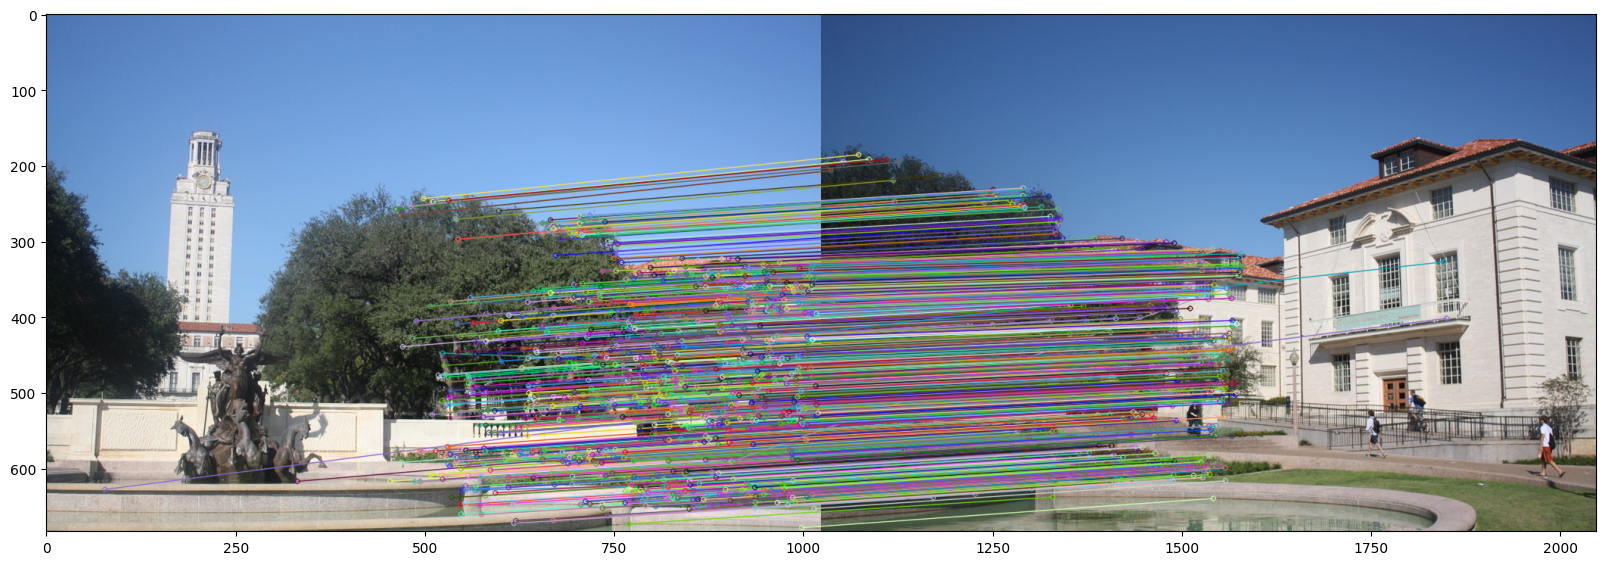

In [16]:
# apply ratio test
matches = []
for m,n in initial_matches:
    if m.distance < 0.70 * n.distance:
        matches.append(m)

# print initial matches
print('Initial matches found: ', len(initial_matches))

# print number of matches after ratio test
print('Number of matches found: ', len(matches))

# plot matches between left and right images
plt.figure(figsize=(20,10))
image_match = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right, matches, None, flags=2)
plt.imshow(image_match[...,::-1])
plt.show()

inliers_homography:  903
Average squared distance:  0.8809756097560976


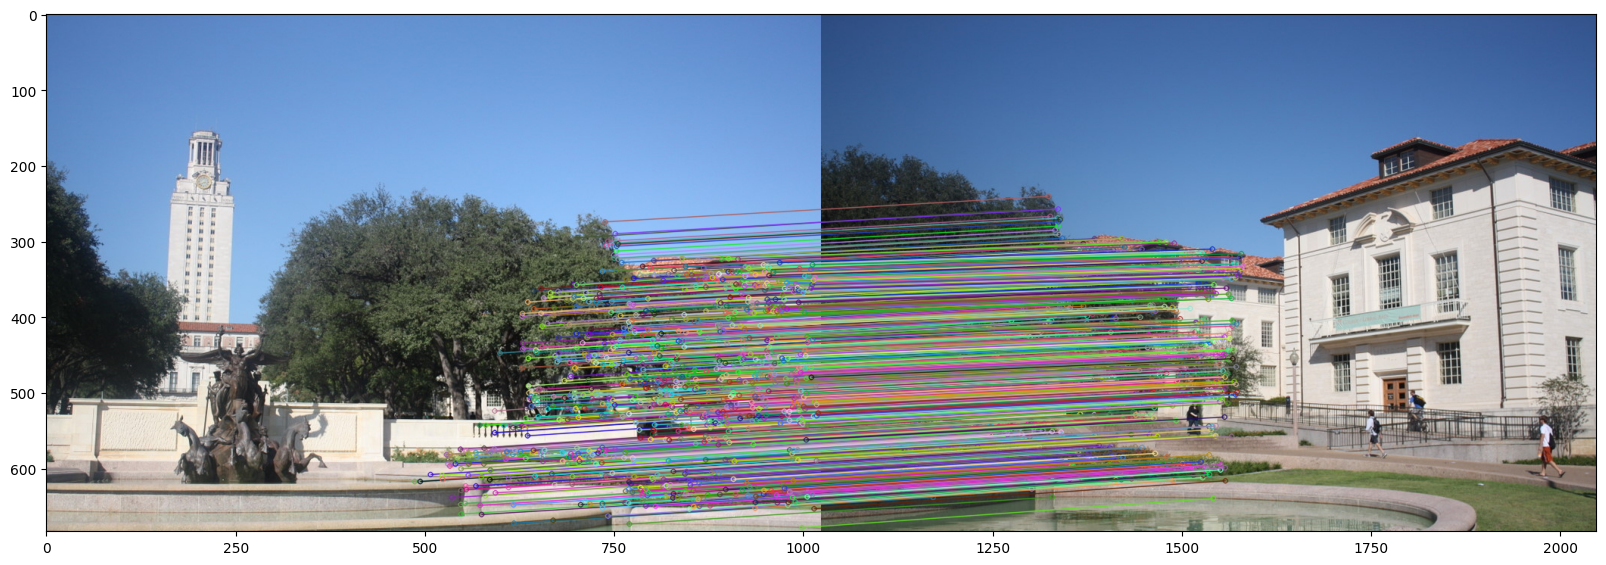

In [17]:
# Use RANSAC to estimate homorgraphy
src_pts = np.float32([keypoints_left[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_right[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Step 4: Estimate the homography matrix
# Ransac HOMOGRAPHY mapping
H, inliers_homography = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# print inliers
print('inliers_homography: ', inliers_homography.sum())
print("Average squared distance: ", inliers_homography.mean())

# plot ransac inliers between left and right images
plt.figure(figsize=(20,10))
image_match = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right, matches, None, 
                              flags=2, matchesMask=inliers_homography.ravel().tolist())
plt.imshow(image_match[...,::-1])
plt.show()

inliers_affine:  829
Average squared distance:  0.8087804878048781


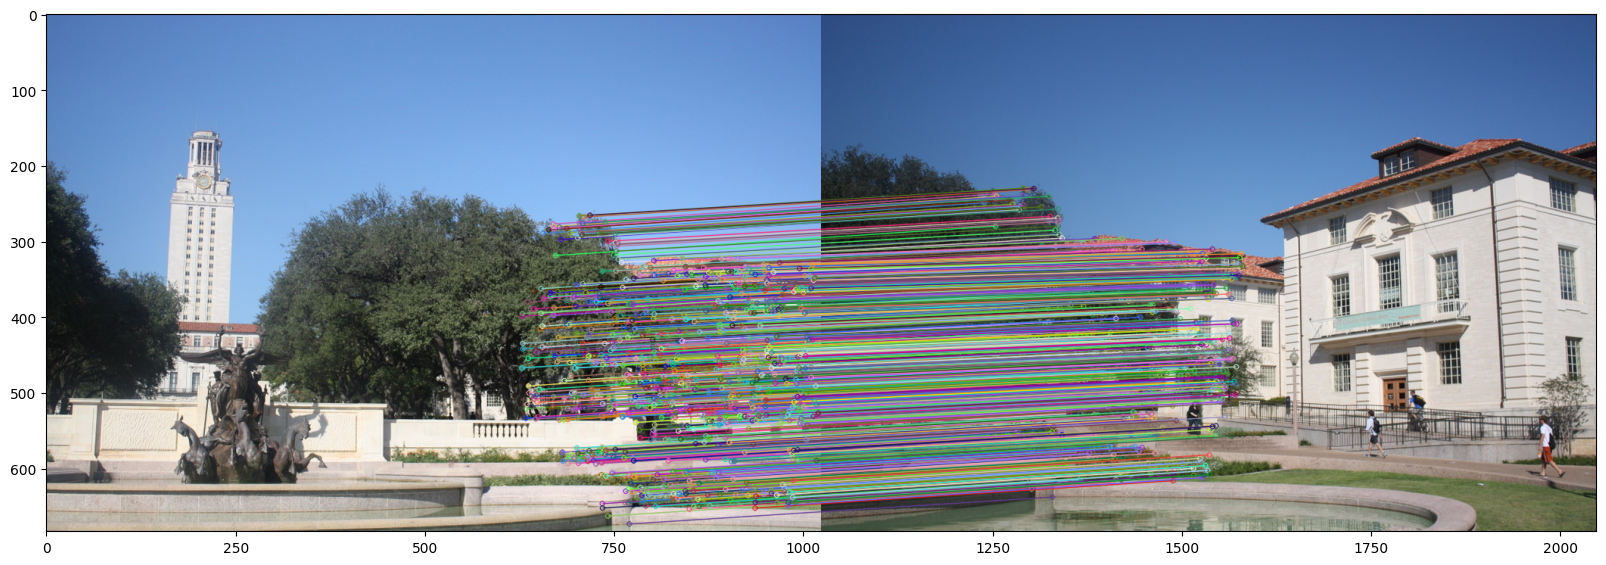

In [18]:
# Use RANSAC to estimate affine matrix
src_pts = np.float32([keypoints_left[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_right[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Step 4: Estimate the homography matrix
# Estimate affine transformation matrix using RANSAC
A, inliers_affine = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=10.0)

# print inliers
print('inliers_affine: ', inliers_affine.sum())
print("Average squared distance: ", inliers_affine.mean())

# plot ransac inliers between left and right images
plt.figure(figsize=(20,10))
image_match = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right, matches, None, 
                              flags=2, matchesMask=inliers_affine.ravel().tolist())
plt.imshow(image_match[...,::-1])
plt.show()

In [26]:
# Use RANSAC to estimate fundamental matrix
src_pts = np.float32([keypoints_left[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_right[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Step 4: Estimate the homography matrix
# Estimate fundamental matrix using RANSAC
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

dst = cv2.warpPerspective(img_left, M, (img_left.shape[1] + img_right.shape[1], img_left.shape[0]))
dst[0:img_right.shape[0], 0:img_right.shape[1]] = img_right
plt.imshow(dst[...,::-1])
plt.show()


inliers:  822
Average squared distance:  0.8019512195121952


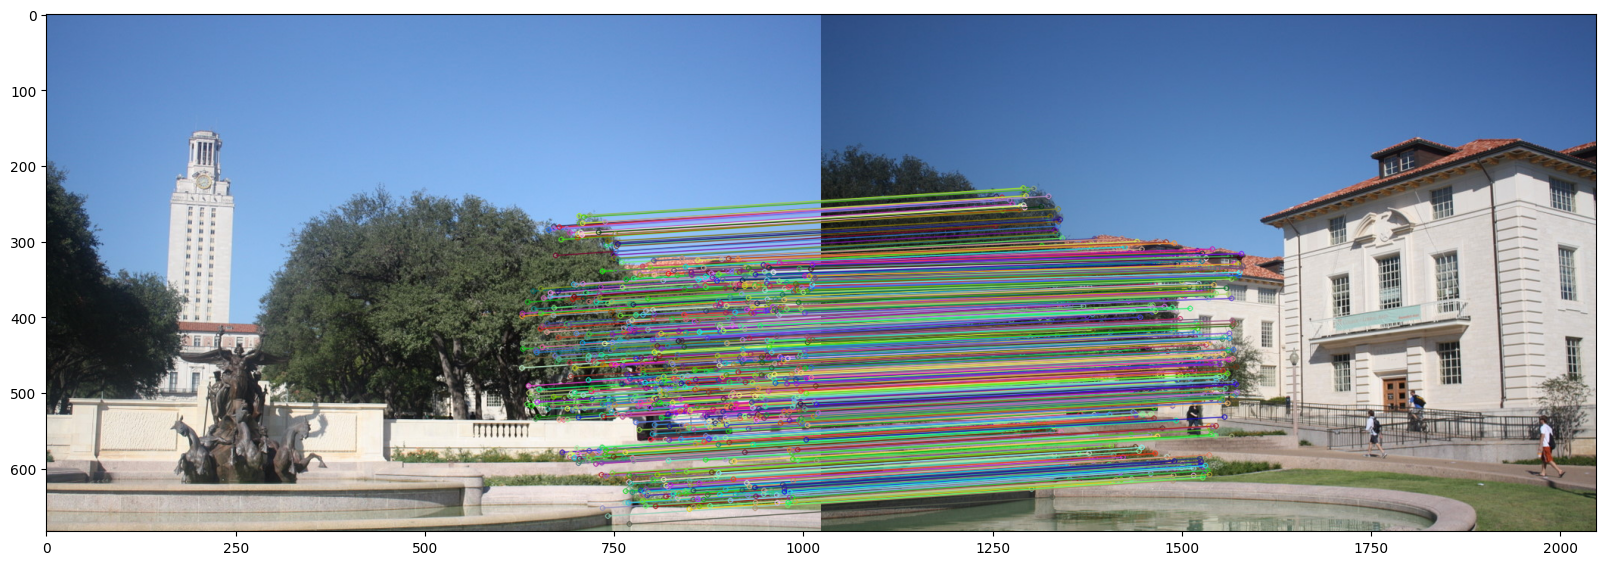

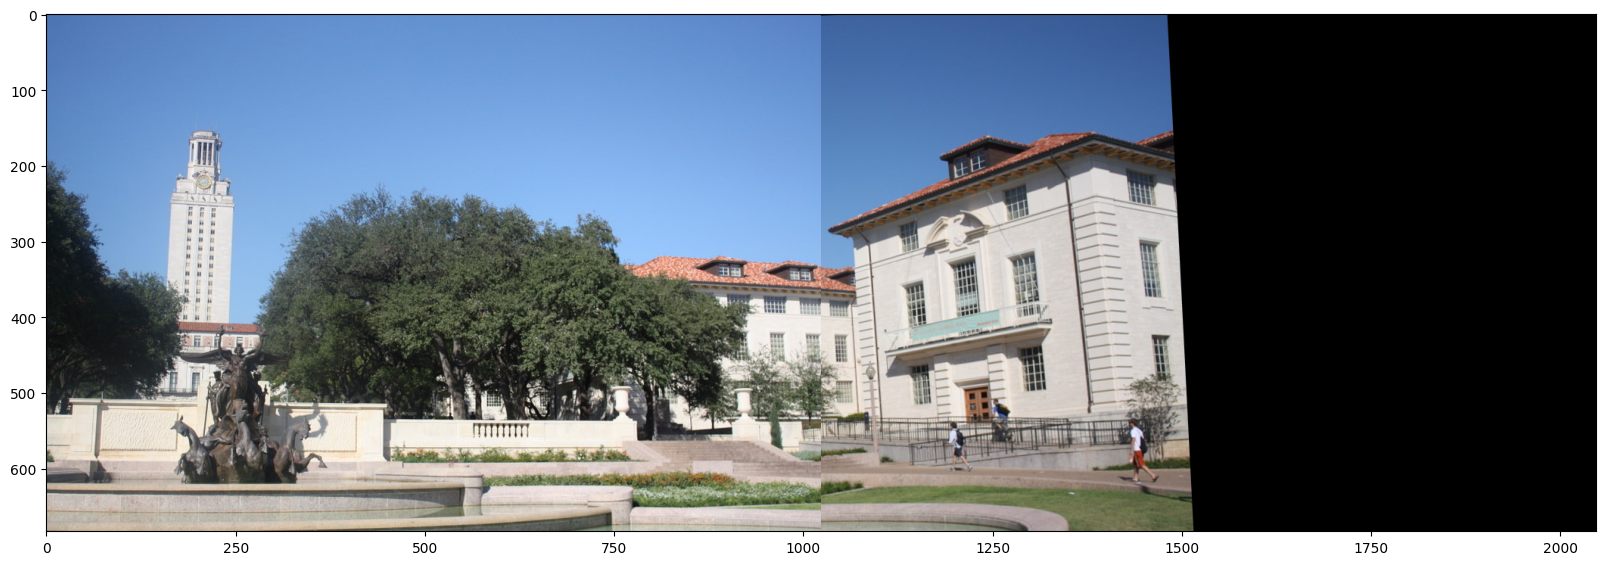

In [21]:
# Use RANSAC to estimate affine transformation and remove outliers
dst_pts = np.float32([keypoints_left[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
src_pts = np.float32([keypoints_right[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Step 4: Estimate the homography matrix
# Ransac affine
A, inliers_affine = cv2.estimateAffinePartial2D(src_pts, dst_pts, method=cv2.RANSAC)


# plot ransac inliers between left and right images
dst = cv2.warpAffine(img_right, A, (img_left.shape[1] + img_right.shape[1], img_left.shape[0]))

# # stitch images together
dst[0:img_left.shape[0], 0:img_left.shape[1]] = img_left

# display warped image
plt.figure(figsize=(20,10))
plt.imshow(dst[...,::-1])
plt.show()

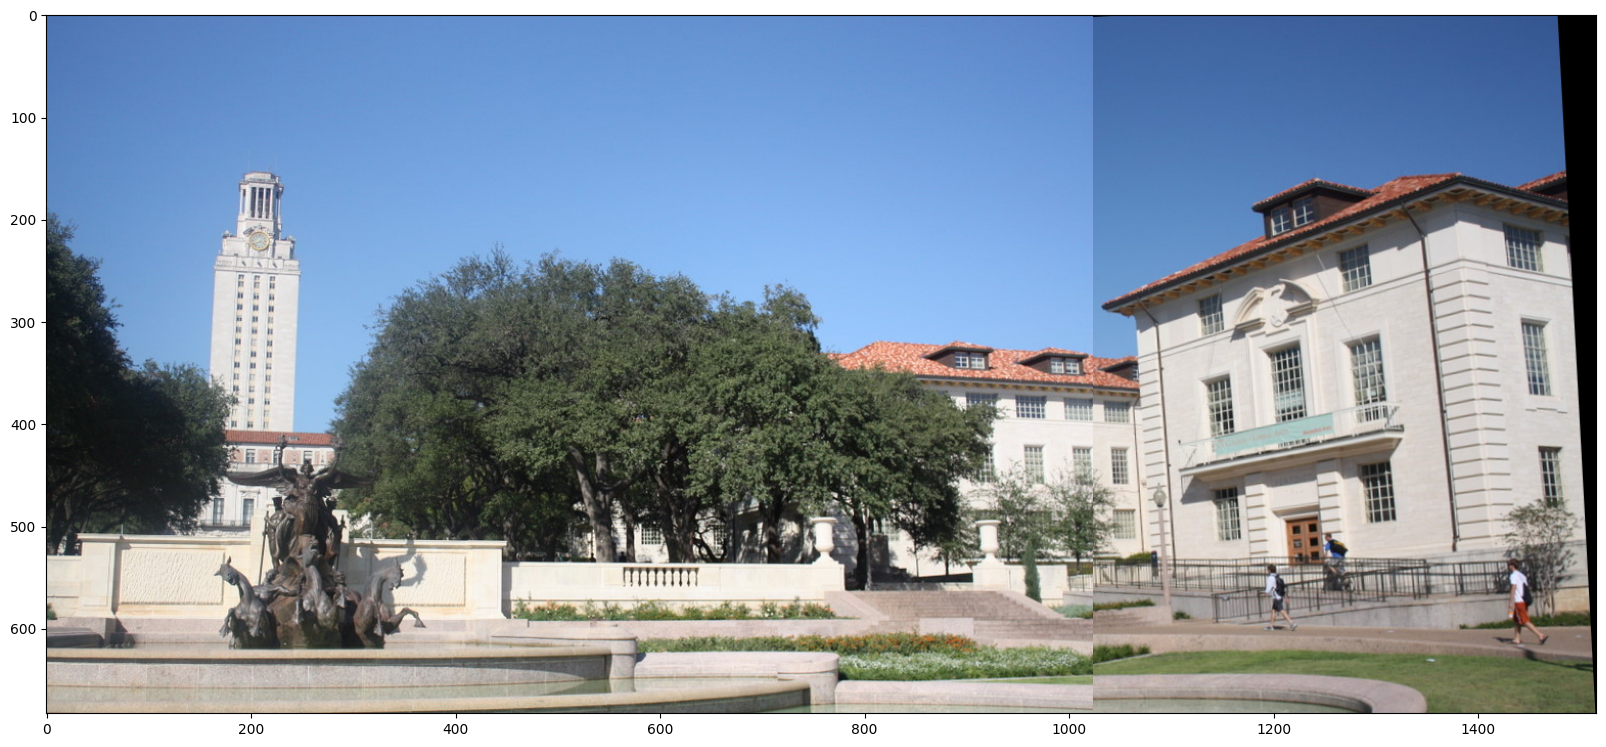

True

In [14]:
# trim black borders
def trim(frame):
    # crop top 
    if not np.sum(frame[0]):
        return trim(frame[1:])
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

# display stitched and cropped image
plt.figure(figsize=(20,10))
plt.imshow(trim(dst[...,::-1]))
plt.show()

# save stitched and cropped image convert to RGB to BGR before saving
cv2.imwrite('stitched_output.jpg', cv2.cvtColor(trim(dst[...,::-1]), cv2.COLOR_RGB2BGR))
